# Convolutional Neural Net (CNN) Fraud Classifier

Another Neural Net Architecture that can handle series data are **Convolutional Neural Nets (CNN)**. They are mainly used in image recognition and *vision* problems in general. But might have some use in Fraud detection.

With CNN's the Neural Net uses convolutional filters, it slides these filters over the data along an axis. For instance in our Transactional data case, the filter would slide along the time-axis. A filter sees a number of transactions (here we see two), depending on the size of the filter as it slides along. This is often named the **kernel size**. The number of elements it moves is named the **stride**, in this case the stride is one. We move the filter/kernel one position at a time.

For time-series we will use a `1d convolution`, the kernel_size is a single number and the 'depth' of the filter is the full 'depth/height' of the series, i.e. it spans the full set of features.

At each position the filter outputs one an only one number; the sum of the element wise multiplication of the filter and the portion of the input it spans. $o= \sum_{i=1}^{ks} \sum_{j=1}^{cc} x_{ij} f_{ij}$, where $ks=kernel size$ and $cc=input channel count$ (i.e. features) or $o = \sum x \bigotimes f$.

Therefore having one filter slide over the input gives us and array, a 1D - Tensor. 

The length of that tensor is shorter or equal the series length. $LengthFiltered = \frac {inputlength - kernelsize + 2 * padding} {stride} + 1$

Intuitively we can think of the output as being an array that shows the 'reaction' of the filter the a certain input (length) area of the input. The filter is a **trainable parameter**, the model will be able to adjust it in the backprop process so the values in the filter help solving the challenge at hand.

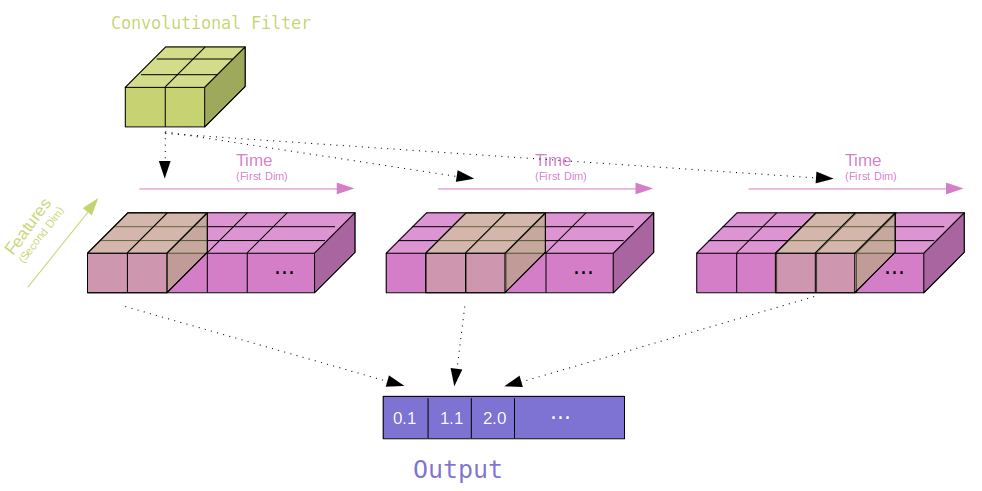



Now, CNN's don't just run **one filter** over the data. They use **multiple filters**, the exact amount is defined as '#Filters' or '#Channels'.

Each filter has an output as described above, each of these arrays has the same length and can be concatenated along the second axis. In the example below five filters then give a seconds dimension size of five.

That gives us a 2-D Tensor where the width depends on the formula specified above (FilteredLength) and the depth/height depends on the number of features/channels specified in the layer. So we end-up with a new block of data that potentially has a different size. Intuitively we can think of that block as showing how each filter reacted to a specified input area. Note that the filters are lined up over a 'reduced' (FilteredLenght) time axis, but the aspect/sequence of time is maintained. All elements along the second axis correspond to the same time portion.

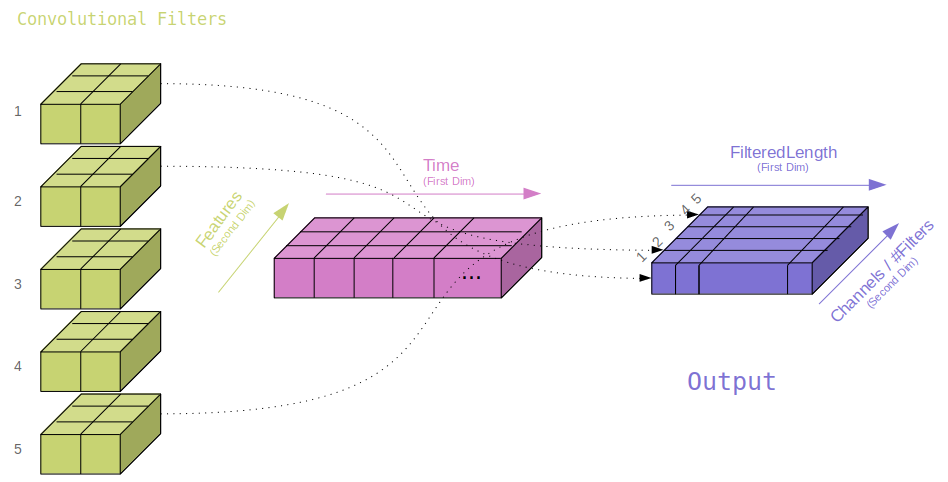

## Some intuition

In order to help build some intuition of how these filters/kernels could help detect Fraud, we'll include a small *purely hypothetical* example.

If we think back to the one-hot encoded vectors showing the 'bin' of the amount. And let's say we have split our amounts in 3 bins, then a small amount might be represented as;

$S_{amount} = \begin{bmatrix}1 \\ 0 \\ 0  \end{bmatrix}$

I.e. there is a 1 in the low range, having a 1 in the high range would mean we have a big amount.

$B_{amount} = \begin{bmatrix}0 \\ 0 \\ 1  \end{bmatrix}$

If we put these in a series, where the columns are the time, then we have a small amount followed by a big amount

$I_{sb} = \begin{bmatrix}1 & 0 \\ 0 & 0 \\ 0 & 1  \end{bmatrix}$

Then if we were to have a filter that looks like so;

$F= \begin{bmatrix}1 & -1 \\ 0 & 0.3 \\ 0 & 1 \end{bmatrix}$

Our input $I_{sb}$ filtered by $F$. Would give __2__. $(1 * 1) + (0 * -1) + (0 * 0) + (0 * 0.3) + (0 * 0) + (1 * 1)$. A fairly `strong positive reaction`.

Reversing the transactions (big followed by small) $I_{bs} = \begin{bmatrix}0 & 1 \\ 0 & 0 \\ 1 & 0 \end{bmatrix}$. Would give a product of __-1__. A `negative reaction`.

We can see that these filters react differently to the sequences and thus give the Neural Net the ability to 'detect' patterns in the series. Maybe important to note is the our filter is time-invariant, it can find small payments followed by big ones anywhere in the sequence, whether it's the 9th and 7th or the 5th and 4th... the reaction will be the same.

Clearly it would not be doing this using just the amount, but all of the input features.

Convolutional Nets can __optimize__ the content of the filters to optimally reduce the loss and solve a specific problem. Above we showed that they theoretically have the ability to come up with a set of filter(s) that can detect certain patterns in the transactional data. The output of the convolutions can then for instance be used to detect various patterns being present in the data.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import gc
import datetime as dt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../../data/bs140513_032310.csv'

## Define Features

### Define Base Features

In [5]:
# Base Features
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

### Define Derived Features

In [6]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

# Categorical Features
amount_bin   = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
age_i        = ft.FeatureIndex('age_i', ft.FEATURE_TYPE_INT_8, age)
gender_i     = ft.FeatureIndex('gender_i', ft.FEATURE_TYPE_INT_8, gender)
merchant_i   = ft.FeatureIndex('merchant_i', ft.FEATURE_TYPE_INT_8, merchant)
category_i   = ft.FeatureIndex('category_i', ft.FEATURE_TYPE_INT_8, category)

# TimeWaves
waves       = ft.FeatureDateTimeWave('time_waves', ft.FEATURE_TYPE_FLOAT_32, date_time, '%j', int(366/2), 2)

# Label Feature
fraud_label  = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

series_size = 5

stacked_ref_series = ft.FeatureSeriesStacked(
    'stacked_ref', ft.FEATURE_TYPE_INT_8, [amount_bin, age_i, gender_i], series_size, merchant
)

# TensorDefinition for the stacked wave
stacked_wave_series = ft.FeatureSeriesStacked(
    'stacked_wave', ft.FEATURE_TYPE_FLOAT_32, [waves], series_size, merchant
)

td_series_ref  = ft.TensorDefinition('stacked_ref', [stacked_ref_series])
td_series_wv   = ft.TensorDefinition('stacked_wave', [stacked_wave_series])
td_referential = ft.TensorDefinition('referential', [merchant_i, category_i])
td_label       = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_series_ref, td_series_wv, td_referential, td_label), file, time_feature=date_time, inference=False)

2023-06-27 22:22:54.367 eng1n3.common.engine           INFO     Start Engine...
2023-06-27 22:22:54.367 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-27 22:22:54.367 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-27 22:22:54.368 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../../data/bs140513_032310.csv
2023-06-27 22:22:59.112 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-27 22:22:59.121 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked_ref using 1 process(es)
2023-06-27 22:22:59.222 e...ureseriesstackedprocessor  INFO     Returning series of type int8.
2023-06-27 22:22:59.223 e...ureseriesstackedprocessor  INFO     Series Shape=[(-1, 5, 3)]
2023-06-27 22:22:59.223 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked_wave using 1 process(es)
2023-06-27 22

In [7]:
ti

TensorInstance with shapes: ((594643, 5, 3), (594643, 5, 4), (594643, 2), (594643, 1))

## Create Data-Sets and Loaders

In [8]:
train, val, test = ti.split_sequential(30000, 100000)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((464643, 5, 3), (464643, 5, 4), (464643, 2), (464643, 1))
((30000, 5, 3), (30000, 5, 4), (30000, 2), (30000, 1))
((100000, 5, 3), (100000, 5, 4), (100000, 2), (100000, 1))


## Create Convolutional Model

Overall this is very similar to the Recurrent example. But here we have a `Convolutional` layer instead of a recurrent layer.

The convolutional body layer will reduce the output in 2 layers and flatten. 

- First it will reduce the input embedding series of transactions (29,5) to a **(12,4)** 2-D tensor. (12 for the output channels and 4 as a result per the *LengthFiltered* formula in the intro to calculate the new length). 
- The second later will further reduce that to a **(24,3)** 2-D tensor. (12 for the output channels of the previous layer and 3 as a result per the formula *LengthFiltered* in the intro to calculate the new length).
- The (24,3) 2-D tensor is flattened to a (72,) 1-D Tensor 

Then we add the embedding of the referential merchant data (33) 1-D Tensor to the (72,) flattened convolutional series data and end-up with a (105,) size tensor which is then fed to the linear layers.

In [9]:
class BankSimConv(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(BankSimConv, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        # Convoltional layers. This adds 2 layers, the first with 12 channels, the second with 24 channels.
        self.conv = mp.ConvolutionalBody1d(
            in_size=self.heads[0].output_size+self.heads[1].output_size,
            series_size=series_size,
            conv_layers=((12, 2, 1), (24, 2, 1)),
            drop_out=0.1
        )
        
        # Set of layers
        self.layers = mp.LinLayer(
            input_size=self.heads[2].output_size+self.conv.output_size, layer_sizes=((16,)), dropout=0.0, bn_interval=1
        )       

        # And a tail layer. For a binary classifier this adds a linear layer to output a size of 1 + Sigmoid
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Run heads logic
        h0 = self.heads[0](x[0])
        h1 = self.heads[1](x[1])
        h2 = self.heads[2](x[2])
        # Pass head 0 and 1 (the series) through the ConvBody. Concatenate them first.
        o = torch.cat((h0, h1), dim=2)
        o = self.conv(o)
        # Concatenate to head 2.
        o = torch.cat((h2, o), dim=1)
        # Run through linear layers.
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a model instance
model = BankSimConv(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

BankSimConv(
  Number of parameters : 5024. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=SeriesTD, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(Name=SeriesTD, lc=Continuous)
    (2): TensorDefinitionHead(
      Name=referential, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(51, 25)
          (1): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (conv): ConvolutionalBody1d(
    (conv_layers): Sequential(
      (conv_01): Conv1d(29, 12, kernel_size=(2,), stride=(1,))
      (relu_01): ReLU()
      (conv_02): Conv1d(12, 24, kernel_size=(2,), stride=(1,))
      (relu_02): ReLU()
      (norm_02): BatchNorm1d(

Graphically this model looks more or less like  this; The final linear layers have been omitted.
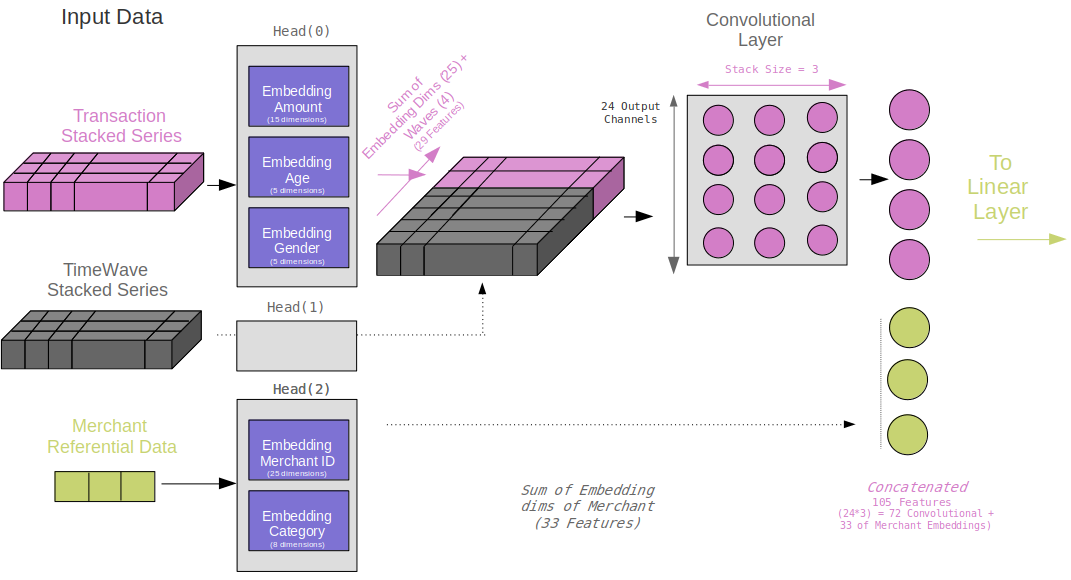

## Train

Finding LR in 200 steps: 100%|██████████| 200/200 [00:01<00:00, 156.67it/s]                                                    


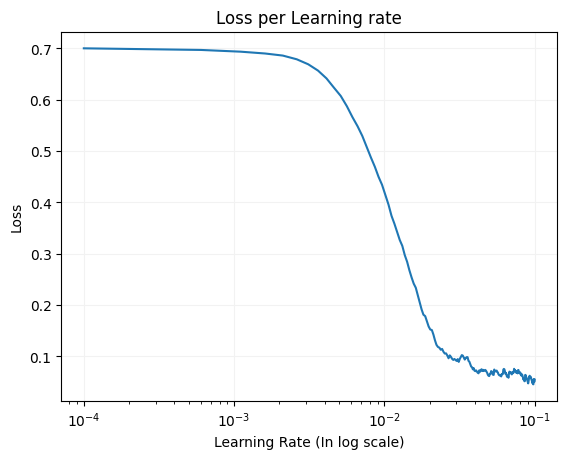

In [10]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = BankSimConv(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);
del m_lr, o_lr, t_lr, lrs
_ = gc.collect()

In [11]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=5e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3866/3866 [00:08<00:00, 475.06it/s, t_loss=0.0328, t_acc=0.99, v_loss=0.0261, v_acc=0.99]      


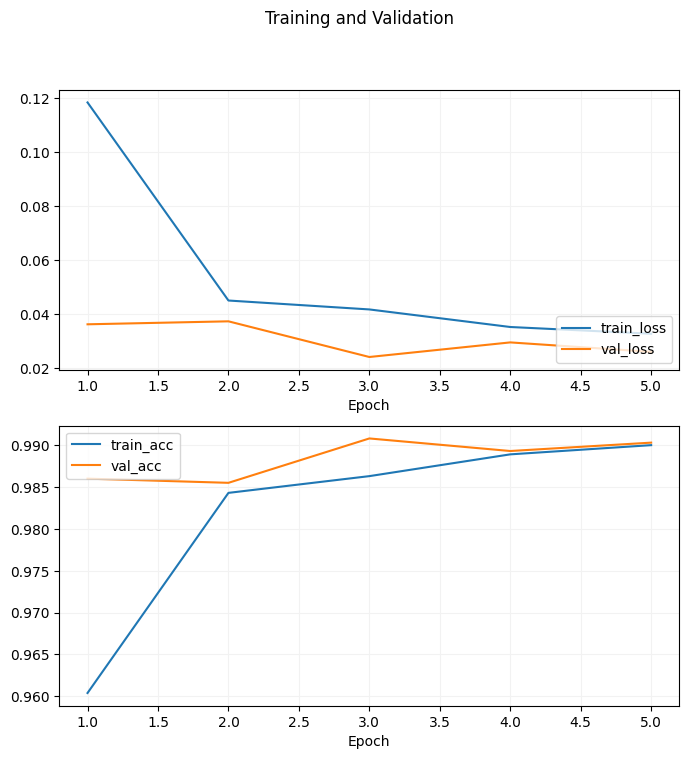

In [14]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

Testing in 782 steps: 100%|██████████████████| 782/782 [00:00<00:00, 985.45it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     98926
         1.0       0.60      0.95      0.74      1074

    accuracy                           0.99    100000
   macro avg       0.80      0.97      0.87    100000
weighted avg       1.00      0.99      0.99    100000


auc score : 0.9982
ap score  : 0.9227
-----------------------------------------------------


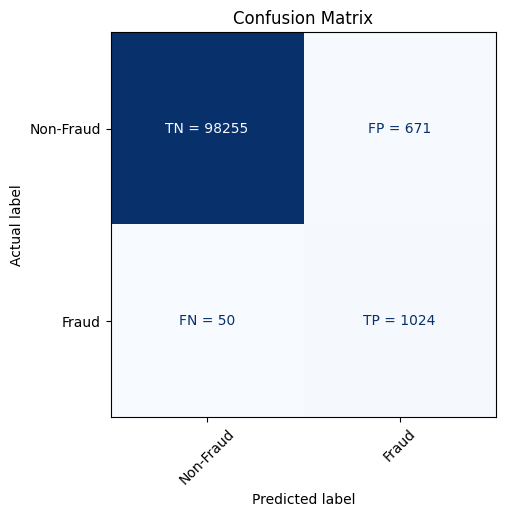

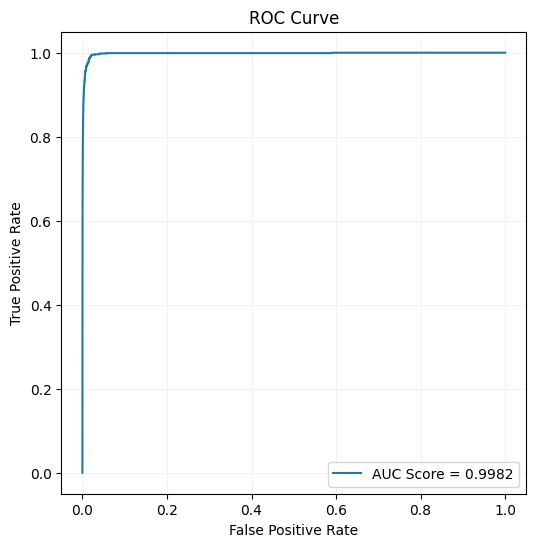

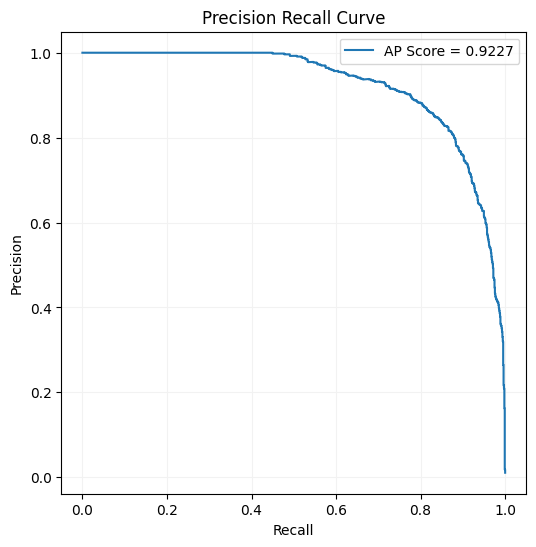

In [15]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5));
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

# Conclusion

This was a simple convolutional example. As is the case with most of the series examples, on this data they are not very convincing. It's not clear if this data has useful sequences and what their key might be.